In [1]:
!pip install pvlib
!pip install cpvlib

import matplotlib.pyplot as plt
import pvlib

from cpvlib import cpvsystem

In [ ]:
# https://doi.org/10.5281/zenodo.3346823
# 0.1 m2, 572 (12 serie x 48 parallel) micro-cells + 4x 6"(15.24 cm) Si-cells in series
# https://doi.org/10.5281/zenodo.3349781
# 35 range IV: 0.7 A, 35 V @DNI 900 W/m2
# Si range IV: 1.7 A, 2.2 V @GNI 950 W/m2 & DNI/GNI=0.7

# https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.pvsystem.calcparams_pvsyst.html
mod_params_cpv = {
    "gamma_ref": 5.524,
    "mu_gamma": 0.003,
    "I_L_ref": 0.96*0.9,
    "I_o_ref": 1.7e-10,
    "R_sh_ref": 5226,
    "R_sh_0": 21000,
    "R_sh_exp": 5.50,
    "R_s": 0.01,
    "alpha_sc": 0.00,
    "EgRef": 3.91,
    "irrad_ref": 1000,
    "temp_ref": 25,
    "cells_in_series": 12,
    "eta_m": 0.32,
    "alpha_absorption": 0.9,
    "b": 0.7,
    "iam_model": 'ashrae',
    "theta_ref": [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60],
    "iam_ref": [1.000, 1.007, 0.998, 0.991, 0.971, 0.966, 0.938, 0.894, 0.830, 0.790, 0.740, 0.649, 0.387],
}

UF_parameters_cpv = {
    "IscDNI_top": 0.96 / 1000,
    "am_thld": 4.574231933073185,
    "am_uf_m_low": 3.906372068620377e-06,
    "am_uf_m_high": -3.0335768119184845e-05,
    "ta_thld": 50,
    "ta_uf_m_low": 4.6781224141650075e-06,
    "ta_uf_m_high": 0,
    "weight_am": 0.2,
    "weight_temp": 0.8,
}

mod_params_cpv.update(UF_parameters_cpv)

# example (NO Insolight) PV module from:
# https://pvpmc.sandia.gov/PVLIB_Matlab_Help/html/pvl_calcparams_PVsyst_help.html
mod_params_flatplate = {
    "gamma_ref": 1.1,
    "mu_gamma": -0.0003,
    "I_L_ref": 8,
    "I_o_ref": 2.2e-9,
    "R_sh_ref": 200,
    "R_sh_0": 8700,
    "R_sh_exp": 5.5,
    "R_s": 0.33,
    "alpha_sc": -0.002,
    "EgRef": 1.121,
    "irrad_ref": 1000,
    "temp_ref": 25,
    "cells_in_series": 4, # 60,
    "eta_m": 0.95,  # pvsyst_celltemp() default value
    "alpha_absorption": 0.97,  # pvsyst_celltemp() default value
    "aoi_limit": 55,
}

In [2]:
lat, lon = 40.4, -3.7

data_pvgis = pvlib.iotools.get_pvgis_tmy(lat, lon)

data = data_pvgis[0].rename(columns={
    'Gb(n)': 'dni',
    'G(h)': 'ghi',
    'Gd(h)': 'dhi',
    'T2m': 'temp_air',
    'WS10m': 'wind_speed',
})

data = data.set_index(
    data.index.map(lambda t: t.replace(year=2010)))

location = pvlib.location.Location(
    latitude=lat, longitude=lon, altitude=695, tz='utc')

solar_zenith = location.get_solarposition(data.index).zenith
solar_azimuth = location.get_solarposition(data.index).azimuth

StaticHybridSystem

In [3]:
static_hybrid_sys = cpvsystem.StaticHybridSystem(
    surface_tilt=30,
    surface_azimuth=180,
    module_cpv=None,
    module_flatplate=None,
    module_parameters_cpv=mod_params_cpv,
    module_parameters_flatplate=mod_params_flatplate,
    modules_per_string=1,
    strings_per_inverter=1,
    inverter=None,
    inverter_parameters=None,
    racking_model="insulated",
    losses_parameters=None,
    name=None,
)

get_effective_irradiance

In [4]:
data['dii_effective'], data['poa_flatplate_static_effective'] = static_hybrid_sys.get_effective_irradiance(
    solar_zenith,
    solar_azimuth,
    #iam_param=0.7,
    #aoi_limit=55,
    dii=None,
    ghi=data['ghi'],
    dhi=data['dhi'],
    dni=data['dni']
)

pvsyst_celltemp

In [5]:
data['temp_cell_35'], data['temp_cell_flatplate'] = static_hybrid_sys.pvsyst_celltemp(
    dii=data['dii_effective'],
    poa_flatplate_static=data['poa_flatplate_static_effective'],
    temp_air=data['temp_air'],
    wind_speed=data['wind_speed']
)

calcparams_pvsyst

In [6]:
diode_parameters_cpv, diode_parameters_flatplate = static_hybrid_sys.calcparams_pvsyst(
    dii=data['dii_effective'],
    poa_flatplate_static=data['poa_flatplate_static_effective'],
    temp_cell_cpv=data['temp_cell_35'],
    temp_cell_flatplate=data['temp_cell_flatplate'],
)

singlediode

In [7]:
dc_cpv, dc_flatplate = static_hybrid_sys.singlediode(
    diode_parameters_cpv, diode_parameters_flatplate)

uf_global (uf_am, uf_temp_air)

In [8]:
airmass_absolute = location.get_airmass(data.index).airmass_absolute

uf_cpv = static_hybrid_sys.get_global_utilization_factor_cpv(airmass_absolute, data['temp_air'])

Power

<IPython.core.display.Javascript object>


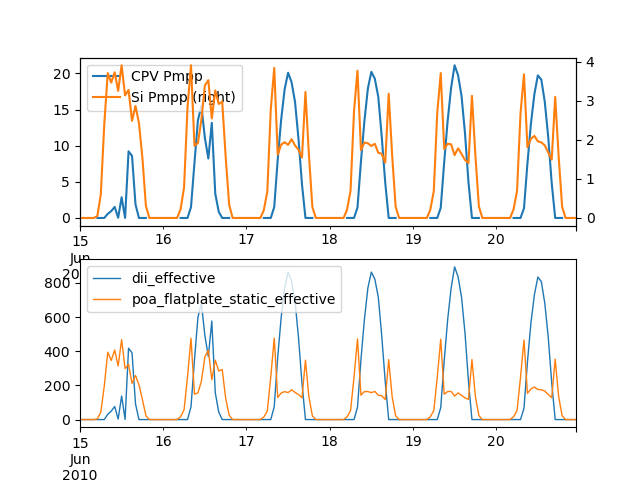

<AxesSubplot:xlabel='time(UTC)'>

In [9]:
cpv_days = dc_cpv['2010-06-15':'2010-06-20']
uf_cpv_days = uf_cpv['2010-06-15':'2010-06-20']
flatplate_days = dc_flatplate['2010-06-15':'2010-06-20']
data_days = data['2010-06-15':'2010-06-20']

fig, axs = plt.subplots(2)

(cpv_days.p_mp * uf_cpv_days).plot(ax=axs[0], legend=True, label="CPV Pmpp")
flatplate_days.p_mp.plot(ax=axs[0], secondary_y=True, legend=True, label="Si Pmpp")
data_days[['dii_effective', 'poa_flatplate_static_effective']].plot(ax=axs[1], linewidth=1)

Energy

In [10]:
energy_cpv = (dc_cpv['p_mp'] * uf_cpv).sum()
energy_flatplate = dc_flatplate['p_mp'].sum()

print(f"E_CPV={energy_cpv:.0f} Wh", f"E_diff={energy_flatplate:.0f} Wh")

E_CPV=25758 Wh E_diff=8833 Wh
